# This is take 3 for Kaggle. Here's where I did my Ridge/LASSO models

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from local_EDA import heat
%matplotlib inline

In [120]:
df = pd.read_csv('./datasets/train.csv')

In [121]:
null_model = np.full_like(df.SalePrice, df.SalePrice.mean())

mean_squared_error(df.SalePrice, null_model, squared=False)

79239.33504472437

Null RMSE 79,239

Trying a different approach to prepare the dataset, shamelessly copying <a href=https://www.kaggle.com/ammar111/house-price-prediction-an-end-to-end-ml-project#data-prep>this guy</a>. It seemed like nothing I was doing was improving my metrics, so I decided to follow a step-by-step walkthrough. The source is linked, and I tried my own EDA already, so hopefully this is kosher.


Checking our null values:

In [3]:
missing = df.isna().sum()
missing = missing[missing > 0]
pct_missing = round(missing*100/df.shape[0], 2)
pd.concat([missing, pct_missing], axis=1, keys=['Missing Vals', 'Percent']).sort_values(by='Missing Vals', ascending=False)

,Missing Vals,Percent
Pool QC,2042,99.56
Misc Feature,1986,96.83
Alley,1911,93.17
Fence,1651,80.50
Fireplace Qu,1000,48.76
Lot Frontage,330,16.09
Garage Yr Blt,114,5.56
Garage Cond,114,5.56
Garage Qual,114,5.56
Garage Finish,114,5.56


Filling our null values, assuming:
- 0 'Pool Size' indicates no pool
- 0 'misc val' indicates no misc feature
- NA in 'Lot Frontage' indicates no frontage (0 feet of street connected to property)

From the data dictionary, we know that:
- NA in 'Alley' means no alley access
- NA in 'Fence' means no fence
- NA in 'Fireplace Qu' means no fireplace

In [4]:
df['Pool QC'].fillna('No Pool', inplace=True)

In [5]:
df['Misc Feature'].fillna('No Feature', inplace=True)

In [6]:
df['Alley'].fillna('No Alley', inplace=True)

In [7]:
df['Fence'].fillna('No Fence', inplace=True)

In [8]:
df['Fireplace Qu'].fillna('No Fireplace', inplace=True)

In [9]:
df['Lot Frontage'].fillna(0, inplace=True)

Filling the 'Garage' null values with 'No Garage' (according to the data dictionary),

or 0 for the numerical 'Garage' columns:


In [10]:
[i for i in df.columns if 'Garage' in i]

['Garage Type',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Cars',
 'Garage Area',
 'Garage Qual',
 'Garage Cond']

In [11]:
for col in ['Garage Cond', 'Garage Qual', 'Garage Finish', 'Garage Type']:
    df[col].fillna('No Garage', inplace=True)

In [12]:
for col in ['Garage Cars', 'Garage Yr Blt', 'Garage Area']:
    df[col].fillna(0, inplace=True)

According to the data dict, NA in `[Bsmt Exposure, BsmtFin Type 2, BsmtFin Type 1, Bsmt Qual, Bsmt Cond]` indicates no basement, so we fill NA values in these columns as such

In [13]:
basement_categoricals = ['Bsmt Exposure', 'BsmtFin Type 2', 'BsmtFin Type 1', 'Bsmt Qual', 'Bsmt Cond']

In [14]:
for col in basement_categoricals:
    df[col].fillna('No Basement', inplace=True)

In [15]:
basement_nums = [i for i in df.columns if 'Bsmt' in i and i not in basement_categoricals]

In [16]:
df[df['Total Bsmt SF'].isna()][basement_categoricals+basement_nums]

,Bsmt Exposure,BsmtFin Type 2,BsmtFin Type 1,Bsmt Qual,Bsmt Cond,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
1327,No Basement,No Basement,No Basement,No Basement,No Basement,NaN,NaN,NaN,NaN,NaN,NaN


Filling numerical `Basement` NaNs with 0, as the NaNs here correspond to our 'No Basement' rows above

In [17]:
for col in basement_nums:
    df[col].fillna(0, inplace=True)

In [18]:
missing = df.isna().sum()
missing = missing[missing > 0]
pct_missing = round(missing*100/df.shape[0], 2)
pd.concat([missing, pct_missing], axis=1, keys=['Missing Vals', 'Percent']).sort_values(by='Missing Vals', ascending=False)

,Missing Vals,Percent
Mas Vnr Type,22,1.07
Mas Vnr Area,22,1.07


Assuming NaNs in `Mas Vnr` columns mean no masonry veneer:

In [19]:
df['Mas Vnr Area'].fillna(0, inplace=True)
df['Mas Vnr Type'].fillna('None', inplace=True)

In [20]:
df.isna().sum().sum()

0

In [21]:
df.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [22]:
df.drop(columns=['PID'], inplace=True)

Now let's look at some distributions, starting with our target variable, `SalePrice`

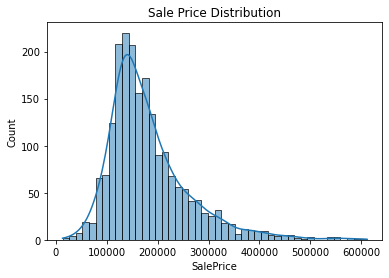

In [23]:
plt.title('Sale Price Distribution')
sns.histplot(df['SalePrice'], kde=True);

As we can see, `SalePrice` is skewed to the right, but not a crazy distribution

Now let's see some correlations between our columns, to easily discover collinear features, and also to pinpoint our highest correlated features with the target (I looked at the heatmap in a new tab)

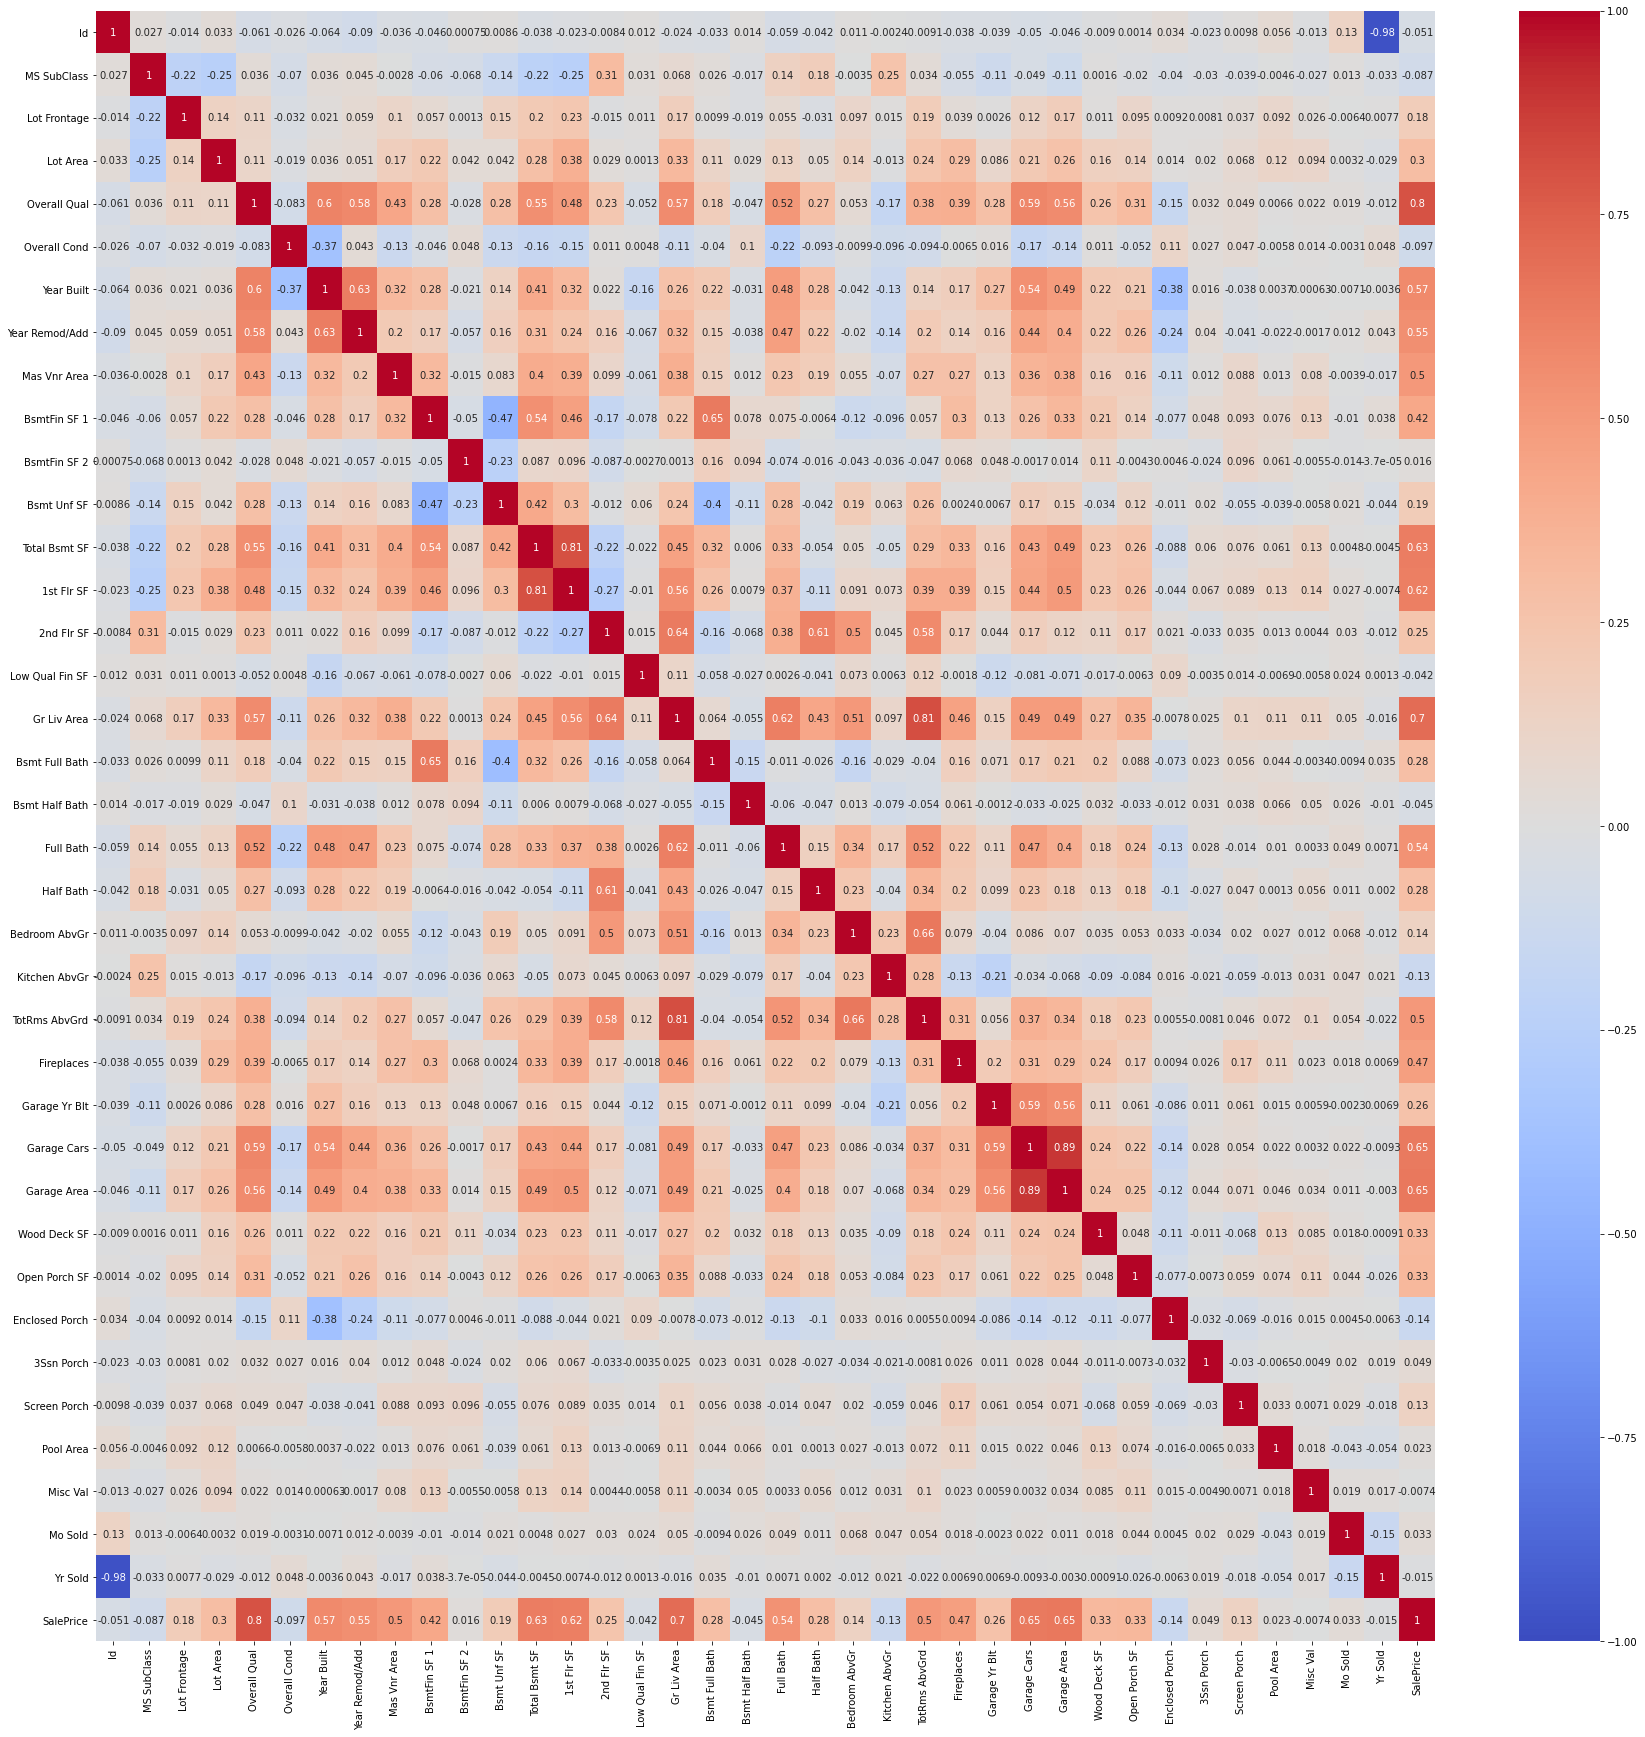

In [24]:
# This is a custom function I made and imported above (from local_EDA). It calculates a 
# correlation matrix, makes a mask, fits it all and reorders the target variable to 
# always be at the bottom for easy reading.
heat(df, 'SalePrice', x=30, y=30, masked=False)

(Probable) Colinear features (>.8 correlation):
- `Total Bsmt SF` with `1st Flr SF`
- `Gr Liv Area` with `TotRms AbvGrd`
- `Garage Cars` with `Garage Area`

We will drop one of each set of colinear features before we model.

Additionally, our highest-correlated features to our target variable are:

|Feature|Correlation|
----------|-----
|`Overall Qual`| 0.8 |
|`Year Built`| 0.57 |
|`Year Remod/Add`| 0.55 |
|`Mas Vnr Area`| 0.5 |
|`Total Bsmt SF`| 0.63 |
|`1st Flr SF`| 0.62 |
|`Gr Liv Area`| 0.7 |
|`Full Bath`| 0.54 |
|`TotRms AbvGrd`| 0.5 |
|`Fireplaces`| 0.47 |
|`Garage Cars`| 0.65 |
|`Garage Area`| 0.65 |


In [25]:
high_corr = ['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'Total Bsmt SF', 
            '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Area']

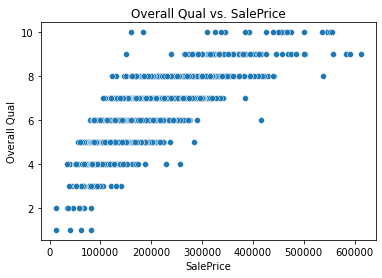

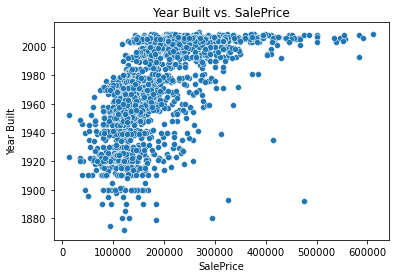

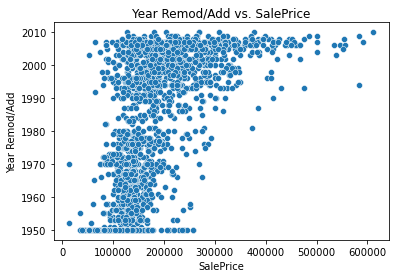

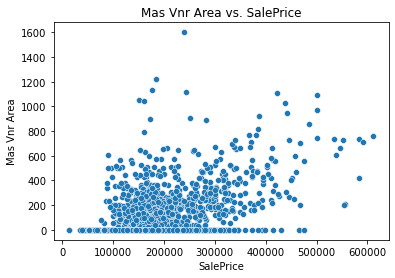

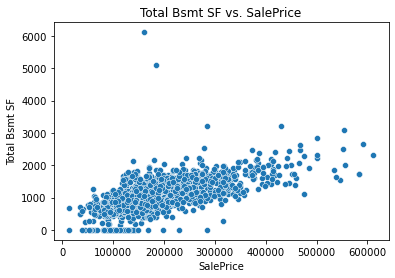

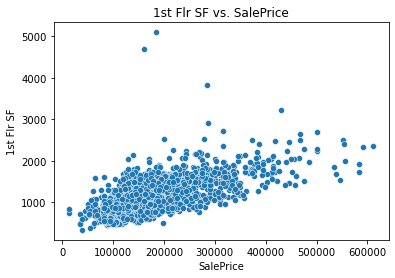

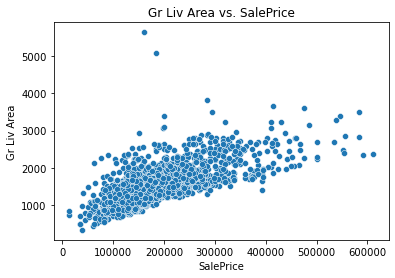

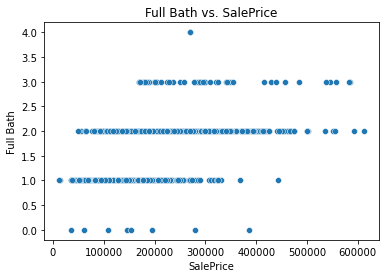

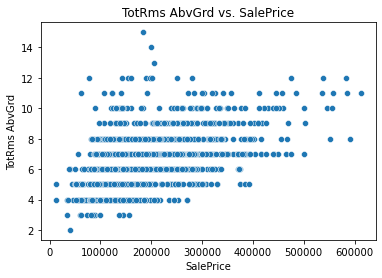

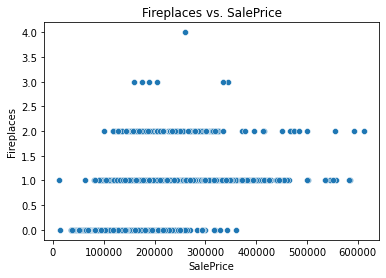

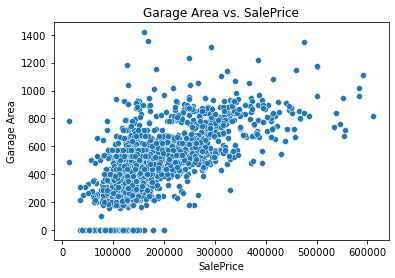

In [26]:
for col in high_corr:
    plt.title(f'{col} vs. SalePrice')
    sns.scatterplot(data=df, x='SalePrice', y=col)
    plt.show()

All of these features have a pretty clear positive, linear relationship with the target

In [27]:
df.drop(columns=['TotRms AbvGrd', 'Garage Cars'], inplace=True)

Instead of dropping one of `Total Bsmt SF` or `1st Flr SF`, we're going to combine all the sqft columns into `total_sqft`

In [28]:
df['total_sqft'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF']

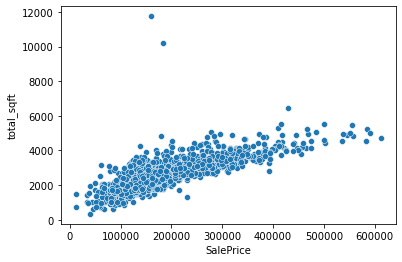

In [29]:
sns.scatterplot(data=df, x='SalePrice', y='total_sqft');

In [30]:
df2 = df[['total_sqft', 'SalePrice', 'Gr Liv Area']]

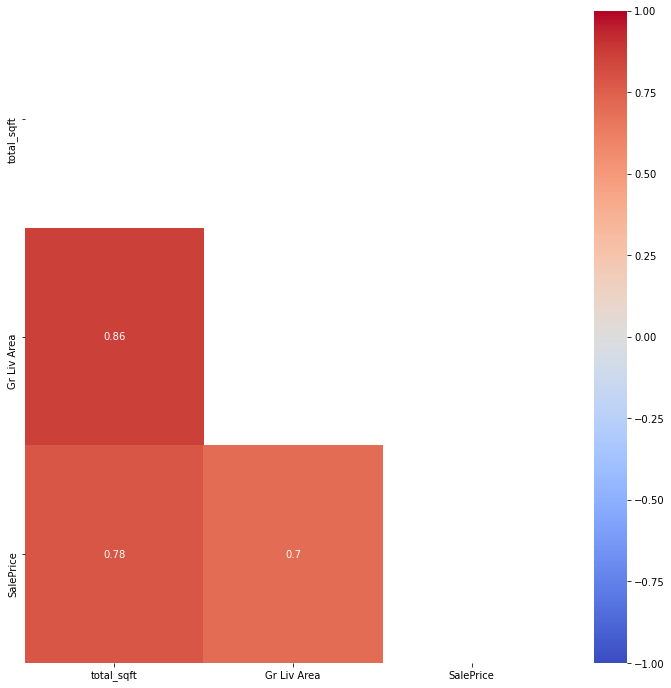

In [31]:
heat(df2, 'SalePrice')

Since our new feature `total_sqft` is so highly correlated with `Gr Liv Area` (and they seem to be describing the same thing) we're going to drop `Gr Liv Area`

In [32]:
df.drop(columns=['Gr Liv Area'], inplace=True)

# Feature Engineering

We're going to map our ordinal columns to numbers instead of strings. To force the model to put appropriate weight in the ordinal categories, we decided to number them 0-n and then square them (high ordinal scores will be more meaningful)

In [33]:
ord_lot = {'Reg': 9, 'IR1': 4, 'IR2': 1, 'IR3': 0}
ord_slope = {'Gtl': 4, 'Mod': 1, 'Sev': 0}
ord_1 = {'Ex': 25, 'Gd': 16, 'TA': 9, 'Fa': 4, 'Po': 1}
ord_bsmt = {'Ex': 25, 'Gd': 16, 'TA': 9, 'Fa': 4, 'Po': 1, 'No Basement': 0}
ord_bsmt_fin = {'GLQ': 36, 'ALQ': 25, 'BLQ': 16,
                'Rec': 9, 'LwQ': 4, 'Unf': 1, 'No Basement': 0}
ord_bsmt_exp = {'Gd': 16, 'Av': 9, 'Mn': 4, 'No': 1, 'No Basement': 0}
ord_elec = {'SBrkr': 16, 'FuseA': 9, 'FuseF': 4, 'FuseP': 1, 'Mix': 0}
ord_func = {'Typ': 49, 'Min1': 36, 'Min2': 25,
            'Mod': 16, 'Maj1': 9, 'Maj2': 4, 'Sev': 1, 'Sal': 0}
ord_fireplace = {'Ex': 25, 'Gd': 16, 'TA': 9,
                 'Fa': 4, 'Po': 1, 'No Fireplace': 0}
ord_garage_fin = {'Fin': 9, 'RFn': 4, 'Unf': 1, 'No Garage': 0}
ord_garage_qc = {'Ex': 25, 'Gd': 16, 'TA': 9, 'Fa': 4, 'Po': 1, 'No Garage': 0}
ord_pool = {'Ex': 16, 'Gd': 9, 'TA': 4, 'Fa': 1, 'No Pool': 0}
ord_fence = {'GdPrv': 16, 'MnPrv': 9, 'GdWo': 4, 'MnWw': 1, 'No Fence': 0}

In [34]:
df['Lot Shape'] = df['Lot Shape'].map(ord_lot)
df['Land Slope'] = df['Land Slope'].map(ord_slope)
for col in ['Exter Qual', 'Exter Cond', 'Heating QC', 'Kitchen Qual']:
    df[col] = df[col].map(ord_1)
for col in ['Bsmt Qual', 'Bsmt Cond']:
    df[col] = df[col].map(ord_bsmt)
df['Bsmt Exposure'] = df['Bsmt Exposure'].map(ord_bsmt_exp)
for col in ['BsmtFin Type 1', 'BsmtFin Type 2']:
    df[col] = df[col].map(ord_bsmt_fin)
df['Central Air'] = df['Central Air'].map({'Y':1,'N':0})
df['Electrical'] = df['Electrical'].map(ord_elec)
df['Functional'] = df['Functional'].map(ord_func)
df['Fireplace Qu'] = df['Fireplace Qu'].map(ord_fireplace)
df['Garage Finish'] = df['Garage Finish'].map(ord_garage_fin)
for col in ['Garage Qual', 'Garage Cond']:
    df[col] = df[col].map(ord_garage_qc)
df['Pool QC'] = df['Pool QC'].map(ord_pool)
df['Fence'] = df['Fence'].map(ord_fence)

In [35]:
df.isna().sum().sum()

0

In [36]:
df.Utilities = df.Utilities.map(lambda x: 1 if x == 'AllPub' else 0)

In [37]:
df.to_csv('./datasets/train_clean_2.csv', index=False)

Going to try One-Hot encoding all remaining nominal categorical columns

In [38]:
df.columns

Index(['Id', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Area', 'Garage Qual', '

In [39]:
nominals = ['MS SubClass', 'MS Zoning', 'Street',
       'Alley', 'Land Contour', 'Lot Config',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Garage Type', 
       'Paved Drive', 'Misc Feature', 'Sale Type',]
df = pd.get_dummies(df, columns=nominals, drop_first=True)

In [40]:
df.shape

(2051, 211)

In [41]:
X = df.drop(columns='SalePrice')
y = df.SalePrice

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)
model = LinearRegression()

In [43]:
cross_val_score(model, X_train, y_train).mean()

0.8547355489453203

Decent cross-validation score, .85

In [44]:
model.fit(X_train, y_train)

LinearRegression()

In [45]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9361489726392116, 0.6770157544141815)

Oof. Too many features, we are ***waaaay*** overfit. Let's try regularization!

In [46]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

I tried doing ElasticNet, but it didn't outperform either of my simpler, unregularized models

In [47]:
enet_alphas = np.linspace(0, 10, 100)
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=0)
enet_model = enet_model.fit(X_train, y_train)

C:\Users\c24th\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\c24th\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 509592726485.69165, tolerance: 759355901.424707
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\c24th\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\c24th\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 509127650331.3096, t

C:\Users\c24th\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:52

limit_output extension: Maximum message size of 10000 exceeded with 14513 characters

In [48]:
enet_y_hat = enet_model.predict(X_test)
mean_squared_error(y_test, enet_y_hat, squared=False)

39701.806710631165

RMSE of almost 40,000. Bleh. My non-regularized models performed better ¯\\\_(ツ)_/¯

I decided to manually take the highest correlations from my new, 211 feature data

In [49]:
corr_df = df.drop("SalePrice", axis=1).apply(lambda x: x.corr(df.SalePrice))

In [50]:
corr_df.sort_values().head(15), corr_df.sort_values(ascending=False).head(15)

(Mas Vnr Type_None       -0.411170
 Garage Type_Detchd      -0.370344
 Foundation_CBlock       -0.355535
 Lot Shape               -0.306125
 MS Zoning_RM            -0.281951
 Roof Style_Gable        -0.249329
 MS SubClass_30          -0.248534
 Garage Type_No Garage   -0.230990
 Sale Type_WD            -0.212542
 Neighborhood_OldTown    -0.208371
 Exterior 1st_Wd Sdng    -0.191734
 Neighborhood_NAmes      -0.189387
 Neighborhood_IDOTRR     -0.189237
 MS SubClass_50          -0.182336
 Neighborhood_Edwards    -0.176119
 dtype: float64,
 Overall Qual        0.800207
 total_sqft          0.783108
 Exter Qual          0.721290
 Kitchen Qual        0.705705
 Bsmt Qual           0.693282
 Garage Area         0.649897
 Total Bsmt SF       0.629303
 1st Flr SF          0.618486
 Year Built          0.571849
 Year Remod/Add      0.550370
 Fireplace Qu        0.548293
 Full Bath           0.537969
 Garage Finish       0.537432
 Foundation_PConc    0.529047
 Mas Vnr Area        0.503579
 dtype: 

In [51]:
bottom_15 = list(zip(corr_df.sort_values().head(15).index, corr_df.sort_values().head(15)))

In [52]:
top_15 = list(zip(corr_df.sort_values(ascending=False).head(15).index, corr_df.sort_values(ascending=False).head(15)))

In [53]:
top_15

[('Overall Qual', 0.8002068702531386),
 ('total_sqft', 0.78310782222218),
 ('Exter Qual', 0.7212897014539473),
 ('Kitchen Qual', 0.7057047359644877),
 ('Bsmt Qual', 0.6932821364824344),
 ('Garage Area', 0.6498968496618991),
 ('Total Bsmt SF', 0.6293030962146706),
 ('1st Flr SF', 0.618486141053395),
 ('Year Built', 0.5718488959135767),
 ('Year Remod/Add', 0.5503696488195576),
 ('Fireplace Qu', 0.5482925663293469),
 ('Full Bath', 0.5379691021121255),
 ('Garage Finish', 0.5374318408482673),
 ('Foundation_PConc', 0.5290468529844162),
 ('Mas Vnr Area', 0.5035785851404634)]

In [54]:
high_corrs = [i[0] for i in top_15] + [i[0] for i in bottom_15]
high_corrs

['Overall Qual',
 'total_sqft',
 'Exter Qual',
 'Kitchen Qual',
 'Bsmt Qual',
 'Garage Area',
 'Total Bsmt SF',
 '1st Flr SF',
 'Year Built',
 'Year Remod/Add',
 'Fireplace Qu',
 'Full Bath',
 'Garage Finish',
 'Foundation_PConc',
 'Mas Vnr Area',
 'Mas Vnr Type_None',
 'Garage Type_Detchd',
 'Foundation_CBlock',
 'Lot Shape',
 'MS Zoning_RM',
 'Roof Style_Gable',
 'MS SubClass_30',
 'Garage Type_No Garage',
 'Sale Type_WD ',
 'Neighborhood_OldTown',
 'Exterior 1st_Wd Sdng',
 'Neighborhood_NAmes',
 'Neighborhood_IDOTRR',
 'MS SubClass_50',
 'Neighborhood_Edwards']

And running a normal linear regression, just to see...

In [55]:
X = df[high_corrs]

In [56]:
y = df.SalePrice

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)

In [58]:
model = LinearRegression()

In [59]:
cross_val_score(model, X_train, y_train).mean()

0.8374884808791352

In [60]:
model.fit(X_train, y_train)

LinearRegression()

In [61]:
y_hat = model.predict(X_test)

In [62]:
mean_squared_error(y_test, y_hat, squared=False)

36642.02344194414

Still overfit, but this was my best RMSE yet at 36,600

In [63]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.8510204272283288, 0.7867821017406827)

In [64]:
nominals

['MS SubClass',
 'MS Zoning',
 'Street',
 'Alley',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Heating',
 'Garage Type',
 'Paved Drive',
 'Misc Feature',
 'Sale Type']

Restarting with a fresh DataFrame

In [65]:
df = pd.read_csv('./datasets/train_clean_2.csv')

Scaling this time before regularizing, I think maybe this was why my ElasticNet went so poorly

In [66]:
ss = StandardScaler()

In [67]:
df.columns

Index(['Id', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Area', 'Garage Qual', '

Dropping categoricals

In [68]:
X = df.drop(columns=['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config',
                     'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
                     'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
                     'Foundation', 'Heating', 'Garage Type', 'Paved Drive', 'Misc Feature',
                     'Sale Type','SalePrice'])
y = df.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)

In [69]:
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

Running RidgeCV and LassoCV

In [70]:
alphas = np.logspace(1, 5, 1000)
ridge = RidgeCV(alphas=alphas)

In [71]:
ridge.fit(Z_train, y_train)

RidgeCV(alphas=array([1.00000000e+01, 1.00926219e+01, 1.01861017e+01, 1.02804473e+01,
       1.03756668e+01, 1.04717682e+01, 1.05687597e+01, 1.06666496e+01,
       1.07654461e+01, 1.08651577e+01, 1.09657929e+01, 1.10673602e+01,
       1.11698682e+01, 1.12733256e+01, 1.13777413e+01, 1.14831241e+01,
       1.15894830e+01, 1.16968270e+01, 1.18051653e+01, 1.19145070e+01,
       1.20248614e+01, 1.21362380e+0...
       8.08924349e+04, 8.16416760e+04, 8.23978568e+04, 8.31610415e+04,
       8.39312950e+04, 8.47086827e+04, 8.54932707e+04, 8.62851257e+04,
       8.70843150e+04, 8.78909065e+04, 8.87049689e+04, 8.95265713e+04,
       9.03557835e+04, 9.11926760e+04, 9.20373200e+04, 9.28897872e+04,
       9.37501502e+04, 9.46184819e+04, 9.54948564e+04, 9.63793480e+04,
       9.72720319e+04, 9.81729841e+04, 9.90822810e+04, 1.00000000e+05]))

In [72]:
ridge.score(Z_test, y_test)

0.7513228812046833

In [73]:
lasso = LassoCV(alphas=alphas)

In [74]:
lasso.fit(Z_train, y_train)

LassoCV(alphas=array([1.00000000e+01, 1.00926219e+01, 1.01861017e+01, 1.02804473e+01,
       1.03756668e+01, 1.04717682e+01, 1.05687597e+01, 1.06666496e+01,
       1.07654461e+01, 1.08651577e+01, 1.09657929e+01, 1.10673602e+01,
       1.11698682e+01, 1.12733256e+01, 1.13777413e+01, 1.14831241e+01,
       1.15894830e+01, 1.16968270e+01, 1.18051653e+01, 1.19145070e+01,
       1.20248614e+01, 1.21362380e+0...
       8.08924349e+04, 8.16416760e+04, 8.23978568e+04, 8.31610415e+04,
       8.39312950e+04, 8.47086827e+04, 8.54932707e+04, 8.62851257e+04,
       8.70843150e+04, 8.78909065e+04, 8.87049689e+04, 8.95265713e+04,
       9.03557835e+04, 9.11926760e+04, 9.20373200e+04, 9.28897872e+04,
       9.37501502e+04, 9.46184819e+04, 9.54948564e+04, 9.63793480e+04,
       9.72720319e+04, 9.81729841e+04, 9.90822810e+04, 1.00000000e+05]))

In [75]:

lasso.score(Z_test, y_test)

0.7345039302012324

Ridge ${R^2}$ - .75

Lasso ${R^2}$ - .73

I was unimpressed. Maybe I'm doing it wrong. I decided to check this feature set on a regular linear regression

In [76]:
model = LinearRegression()

In [77]:
model.fit(Z_train, y_train)

LinearRegression()

In [78]:
model.score(Z_train, y_train), model.score(Z_test, y_test)

(0.8902462880042085, 0.728930259705552)

In [79]:
y_hat = model.predict(Z_test)

In [80]:
mean_squared_error(y_test, y_hat, squared=False)

41315.03633342425

Similar $R^2$ score to the regularized models, crappy RMSE

Let's try log-transforming the target variable

In [81]:
X = df.drop(columns=['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config',
                     'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
                     'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
                     'Foundation', 'Heating', 'Garage Type', 'Paved Drive', 'Misc Feature',
                     'Sale Type','SalePrice'])
y = np.log(df.SalePrice)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)

And scaling the rest of the variables

In [82]:
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [83]:
model = LinearRegression()

In [84]:
model.fit(Z_train, y_train)

LinearRegression()

In [85]:
model.score(Z_train, y_train), model.score(Z_test, y_test)

(0.899552024804694, 0.7926100613878599)

Slightly better $R^2$ at .79, but still wildly overfit

In [86]:
y_hat = np.exp(model.predict(Z_test))

In [87]:
np.exp(y_test)

826     124000.0
1395    143000.0
1160    325624.0
2045    394617.0
1454     95000.0
          ...   
1946    143500.0
429     180000.0
1847    119000.0
210     149000.0
642     126000.0
Name: SalePrice, Length: 513, dtype: float64

In [88]:
mean_squared_error(np.exp(y_test), y_hat, squared=False)

127720.23686568202

Disgusting RMSE. 127,720 is four times the RMSE I was getting with an unscaled model

In [89]:
model = LinearRegression()

In [90]:
model.fit(X_train, y_train)

LinearRegression()

In [91]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.8995520248323842, 0.7926100627563255)

In [92]:
y_hat = model.predict(X_test)

In [93]:
mean_squared_error(y_test, y_hat, squared=False)

0.18620515164133009

Let's try *all* the features (categories too, OHE'd) against a log-target

In [94]:
df = pd.get_dummies(df, drop_first=True)

In [95]:
X = df.drop(columns='SalePrice')
y = np.log(df.SalePrice)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9370184724381281, 0.75400243579688)

.75 $R^2$, and crazy overfit

In [97]:
y_hat = np.exp(model.predict(X_test))
mean_squared_error(np.exp(y_test), y_hat, squared=False)

132131.3057591826

Insane RMSE, 132,131

In [98]:
X = df.drop(columns='SalePrice')
y = df.SalePrice

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9353907823702121, 0.6745913521210458)

I tried running all the features against an untouched target as well; it performed even worse

So I decided to get more picky with my features

In [100]:
bottom_15 = list(zip(corr_df.sort_values().head(15).index, corr_df.sort_values().head(15)))
bottom_15

[('Mas Vnr Type_None', -0.4111695573823815),
 ('Garage Type_Detchd', -0.37034443865764877),
 ('Foundation_CBlock', -0.35553521520011944),
 ('Lot Shape', -0.30612500654322056),
 ('MS Zoning_RM', -0.2819514318924289),
 ('Roof Style_Gable', -0.24932901330452895),
 ('MS SubClass_30', -0.24853416697324712),
 ('Garage Type_No Garage', -0.23099037106839507),
 ('Sale Type_WD ', -0.21254174769346093),
 ('Neighborhood_OldTown', -0.2083710127541113),
 ('Exterior 1st_Wd Sdng', -0.19173446228826785),
 ('Neighborhood_NAmes', -0.18938685934090524),
 ('Neighborhood_IDOTRR', -0.18923742256009393),
 ('MS SubClass_50', -0.18233641032022208),
 ('Neighborhood_Edwards', -0.17611881350859743)]

In [101]:
top_30 = list(zip(corr_df.sort_values(ascending=False).head(30).index, corr_df.sort_values(ascending=False).head(30)))
top_30

[('Overall Qual', 0.8002068702531386),
 ('total_sqft', 0.78310782222218),
 ('Exter Qual', 0.7212897014539473),
 ('Kitchen Qual', 0.7057047359644877),
 ('Bsmt Qual', 0.6932821364824344),
 ('Garage Area', 0.6498968496618991),
 ('Total Bsmt SF', 0.6293030962146706),
 ('1st Flr SF', 0.618486141053395),
 ('Year Built', 0.5718488959135767),
 ('Year Remod/Add', 0.5503696488195576),
 ('Fireplace Qu', 0.5482925663293469),
 ('Full Bath', 0.5379691021121255),
 ('Garage Finish', 0.5374318408482673),
 ('Foundation_PConc', 0.5290468529844162),
 ('Mas Vnr Area', 0.5035785851404634),
 ('Fireplaces', 0.471092893762989),
 ('Heating QC', 0.46330205966425864),
 ('Neighborhood_NridgHt', 0.44864681340299206),
 ('Bsmt Exposure', 0.42591858506772345),
 ('BsmtFin SF 1', 0.4238559133946794),
 ('BsmtFin Type 1', 0.3920697238244425),
 ('Sale Type_New', 0.3581019691173569),
 ('Garage Type_Attchd', 0.35787902815727923),
 ('MS SubClass_60', 0.3554214620632627),
 ('Exterior 1st_VinylSd', 0.34214555855939066),
 ('Exte

In [102]:
high_corr = [i[0] for i in top_30 if i[1] > .3] + [i[0] for i in bottom_15 if i[1] < -.3]

Using only features with above +-.3 correlation

In [103]:
high_corr.remove('MS SubClass_60')

In [104]:
X = df[high_corr]
y = df.SalePrice

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.8653899197776387, 0.7796337543201766)

.77 $R^2$, doing better, and not nearly as overfit

In [106]:
y_hat = model.predict(X_test)
mean_squared_error(y_test, y_hat, squared=False)

37251.190393954676

Much more reasonable RMSE, 37,251. Not great, but much better than some of those models.

Now running Ridge and Lasso against the same features:

In [107]:
alphas = np.linspace(0.0001, 5, 5000)
lasso = LassoCV(alphas=alphas, n_jobs=-1, max_iter=10000, normalize=False)

In [108]:
lasso.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-04, 1.10018004e-03, 2.10036007e-03, ...,
       4.99799964e+00, 4.99899982e+00, 5.00000000e+00]),
        max_iter=10000, n_jobs=-1)

In [109]:
lasso.score(X_train, y_train), lasso.score(X_test, y_test)

(0.8653873857719856, 0.7796444843996608)

In [114]:
y_hat_lasso = lasso.predict(X_test)

In [115]:
mean_squared_error(y_test, y_hat_lasso, squared=False)

37250.28346490493

37,250 RMSE, not bad, but not outperforming my other models

In [110]:
ridge = RidgeCV(alphas=alphas)

In [111]:
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-04, 1.10018004e-03, 2.10036007e-03, ...,
       4.99799964e+00, 4.99899982e+00, 5.00000000e+00]))

In [112]:
ridge.score(X_train, y_train), ridge.score(X_test, y_test)

(0.8653401230822051, 0.7796948256143356)

In [117]:
y_hat_ridge = ridge.predict(X_test)

In [118]:
mean_squared_error(y_test, y_hat_ridge, squared=False)

37246.02822394895

37,246 RMSE. Almost identical to the Lasso above